## Capstone Project - The Battle of the Neighborhoods¶
Applied Data Science Capstone by IBM/Coursera

### Table of contents
* Introduction: Business Problem
* Data
* Analysis
* Results and Discussion
* Conclusion

### Introduction: Business Problem 

In this project, I will try to find proper locations for opening up coffee shops. Specifically, this report will be targeted to stakeholders interested in opening an Coffee Shop in Downtown Toronto. Since there are lots of coffee shops in different neighbourhoods in Dwontown Toronto, I will try to detect locations that have few coffee shops. I am also particularly interested in areas with no coffee shop in vicinity. I will leverage the Foursquare location data to explore different venues in different neighbourhoods. Then, I present and recommend final locations to stakeholders.

### Data

Based on definition of the problem, factors that will influence my decission are:

* number of existing coffee shops in the neighborhood,
* number of and distance to coffee shops in the neighborhood.

Following data sources will be needed to extract/generate the required information:

* Wikipedia List_of_postal_codes_of_Canada.
* Geospatial_Coordinates.csv (this file includes locations of neighbourhoods).
* Number of Coffee shops and locations in every neighborhood will be obtained using Foursquare API.

In [42]:
from bs4 import BeautifulSoup 
import requests  
import numpy as np
import pandas as pd

In [43]:
url= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib") 
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
#print(table_contents)


In [44]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [45]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [46]:


df_location = pd.read_csv("Geospatial_Coordinates.csv")
df_location.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [47]:
df_location_revised= df_location.rename(columns = {'Postal Code': 'PostalCode'}, inplace = False)
df_location_revised.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


####  Merge the dataframe with Postal code, Borough, and Neighbourhood with dataframe for Geospatial_Coordinates

In [48]:
Neighbourhood = pd.merge(df, df_location_revised, on='PostalCode')
Neighbourhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [49]:
!pip3 install geocoder
!pip3 install geopy

In [50]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### Slice the original dataframe and create a new dataframe of the Toronto data.

In [51]:
Toronto_data = Neighbourhood[Neighbourhood['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [52]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081162653639.


#### Visualize Downtown Toronto and its neighborhoods.

In [53]:
# create map of Downtown Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [55]:
LIMIT = 100
radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes = Toronto_data['Latitude'],
                                   longitudes = Toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [56]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1063, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


## Analysis

In [58]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']],prefix="",prefix_sep="")
Toronto_onehot['Neighborhood']=Toronto_venues['Neighborhood']
Toronto_onehot = Toronto_onehot.set_index('Neighborhood')

# mid = Toronto_onehot['Neighborhood']
# df.drop(labels=['Neighborhood'], axis=1,inplace = True)
# df.insert(0, 'Neighborhood', mid)
#fixed_columns = [Toronto_onehot.columns[-1]]+list(Toronto_onehot.columns[:-1])
#Toronto_onehot = Toronto_onehot[fixed_columns]
Toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doner Restaurant,Donut Shop,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Let's group rows by neighborhood and taking the mean of the frequency of occurrence of each category.

In [61]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doner Restaurant,Donut Shop,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.0,0.0,0.021739,0.000000,0.0,0.0,0.000000,0.021739,0.065217,0.000000,0.000000,0.0,0.021739,0.021739,0.0,0.043478,0.0,0.0,0.021739,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.021739,0.000000,0.021739,0.0,0.0,0.021739,0.0,0.0,0.000000,0.086957,0.065217,0.0,0.0,0.0,0.0,0.021739,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.021739,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.043478,0.000000,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.021739,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.021739,0.0,0.021739,0.021739,0.021739,0.0,0.000000,0.0,0.000000,0.0,0.0,0.021739,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.021739,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.021739,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.021739,0.000000,0.000000,0.0,0.065217,0.0,0.0000,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.021739,0.0,0.0,0.021739,0.000000,0.021739,0.000000,0.0,0.0,0.021739,0.000000,0.000000,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.0625,0.000000,0.0

#### Let's write a function to sort the venue in descending order.

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_category = row.iloc[1:]
    row_category_sorted = row_category.sort_values(ascending=False)
    return row_category_sorted.index.values[0:num_top_venues]

#### Let's create the new dataframe and display the top 5 venues for each neighborhood.

In [63]:
num_top_venues =5
indicators = ['st','nd','rd']

# create columns according to number of top venues
columns=['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicator[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe 
sorted_venue_neighborhood = pd.DataFrame(columns=columns)
sorted_venue_neighborhood['Neighborhood'] = Toronto_grouped ['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    sorted_venue_neighborhood.iloc[ind,1:]= return_most_common_venues(Toronto_grouped.iloc[ind,:], num_top_venues)
    
sorted_venue_neighborhood


,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Cocktail Bar,Sandwich Place,Coffee Shop,Bakery,Beer Bar
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Sculpture Garden,Boutique,Boat or Ferry
2,Central Bay Street,Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Japanese Restaurant
3,Christie,Grocery Store,Café,Park,Restaurant,Baby Store
4,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Coffee Shop,Restaurant,Gay Bar
5,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Sandwich Place,Hotel,Restaurant
6,"First Canadian Place, Underground city",Coffee Shop,Sandwich Place,Café,Hotel,Japanese Restaurant
7,"Garden District, Ryerson",Coffee Shop,Clothing Store,Sandwich Place,Café,Japanese Restaurant
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Café,Hotel,Scenic Lookout,Pizza Place
9,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Vegetarian / Vegan Restaurant,Bakery,Bar


In [64]:
from sklearn.cluster import KMeans

#### Let's put the neighbourhoods in 5 clusters.

In [65]:
k=5
Toronto_grouped_clustering= Toronto_grouped.drop('Neighborhood',1)
kmeans= KMeans(n_clusters=k, random_state=40).fit(Toronto_grouped_clustering)
kmeans.labels_[0:10]

array([3, 4, 1, 2, 1, 1, 1, 1, 1, 3])

#### Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood. 

In [66]:
sorted_venue_neighborhood.insert(0, 'Cluster Number', kmeans.labels_)
Toronto_merged = Toronto_data
Toronto_merged = Toronto_merged.join(sorted_venue_neighborhood.set_index('Neighborhood'), on='Neighborhood')



In [77]:
Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Café
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Sandwich Place,Café,Japanese Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,Italian Restaurant,Cocktail Bar,Restaurant
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,3,Cocktail Bar,Sandwich Place,Coffee Shop,Bakery,Beer Bar
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Japanese Restaurant


In [70]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude,longitude],zoom_start=11)

x=np.arange(k)
ys=[i+x+(i*x)**2 for i in range(k)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

makers_colors=[]
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Number']):
    label=folium.Popup(str(poi)+'Cluster'+str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters


#### Let's check different clusters.

In [71]:
Toronto_merged.loc[Toronto_merged['Cluster Number']==0, Toronto_merged.columns[[2]+list(range(5,Toronto_merged.shape[1]))]]

,Neighborhood,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Rosedale,0,Park,Playground,Trail,Yoga Studio,Cosmetics Shop


In [72]:
Toronto_merged.loc[Toronto_merged['Cluster Number']==1, Toronto_merged.columns[[2]+list(range(5,Toronto_merged.shape[1]))]]

,Neighborhood,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Regent Park, Harbourfront",1,Coffee Shop,Bakery,Pub,Park,Café
1,"Garden District, Ryerson",1,Coffee Shop,Clothing Store,Sandwich Place,Café,Japanese Restaurant
4,Central Bay Street,1,Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Japanese Restaurant
6,"Richmond, Adelaide, King",1,Coffee Shop,Café,Sandwich Place,Clothing Store,Gym
7,"Harbourfront East, Union Station, Toronto Islands",1,Coffee Shop,Café,Hotel,Scenic Lookout,Pizza Place
8,"Toronto Dominion Centre, Design Exchange",1,Coffee Shop,Café,Hotel,Sandwich Place,Asian Restaurant
9,"Commerce Court, Victoria Hotel",1,Coffee Shop,Café,Sandwich Place,Hotel,Restaurant
10,"University of Toronto, Harbord",1,Café,Coffee Shop,Sandwich Place,Pub,Bar
14,"St. James Town, Cabbagetown",1,Coffee Shop,Bakery,Café,Italian Restaurant,Restaurant
15,"First Canadian Place, Underground city",1,Coffee Shop,Sandwich Place,Café,Hotel,Japanese Restaurant


In [73]:
Toronto_merged.loc[Toronto_merged['Cluster Number']==2, Toronto_merged.columns[[2]+list(range(5,Toronto_merged.shape[1]))]]

,Neighborhood,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Christie,2,Grocery Store,Café,Park,Restaurant,Baby Store


In [74]:
Toronto_merged.loc[Toronto_merged['Cluster Number']==3, Toronto_merged.columns[[2]+list(range(5,Toronto_merged.shape[1]))]]

,Neighborhood,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,St. James Town,3,Coffee Shop,Café,Italian Restaurant,Cocktail Bar,Restaurant
3,Berczy Park,3,Cocktail Bar,Sandwich Place,Coffee Shop,Bakery,Beer Bar
11,"Kensington Market, Chinatown, Grange Park",3,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Bakery,Bar


In [78]:
Toronto_merged.loc[Toronto_merged['Cluster Number']==4, Toronto_merged.columns[[2]+list(range(5,Toronto_merged.shape[1]))]]

,Neighborhood,Cluster Number,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,"CN Tower, King and Spadina, Railway Lands, Har...",4,Airport Service,Airport Lounge,Sculpture Garden,Boutique,Boat or Ferry


#### Let's perform some data analysis and derive some additional info from the data. I create the dataframe for only Coffee Shop and Cafe.

In [94]:
Toronto_Coffee = Toronto_venues.loc[(Toronto_venues['Venue Category'] == 'Coffee Shop') | (Toronto_venues['Venue Category'] == 'Café')]
Toronto_Coffee.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
8,"Regent Park, Harbourfront",43.65426,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop
9,"Regent Park, Harbourfront",43.65426,-79.360636,Sumach Espresso,43.658135,-79.359515,Coffee Shop
10,"Regent Park, Harbourfront",43.65426,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
22,"Regent Park, Harbourfront",43.65426,-79.360636,Caffe Furbo,43.649970,-79.358849,Café


In [81]:
# create map of Downtown Toronto using latitude and longitude values
map_coffee_shop = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_Coffee['Neighborhood Latitude'], Toronto_Coffee['Neighborhood Longitude'], Toronto_Coffee['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffee_shop)  
    
map_coffee_shop

#### Let's show how many coffee shops and cafe in each neighbourhoods.

In [84]:
Toronto_Coffee_grouped = Toronto_Coffee.groupby('Neighborhood').count()
Toronto_Coffee_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,4,4,4,4,4,4
Central Bay Street,13,13,13,13,13,13
Christie,4,4,4,4,4,4
Church and Wellesley,4,4,4,4,4,4
"Commerce Court, Victoria Hotel",20,20,20,20,20,20
"First Canadian Place, Underground city",21,21,21,21,21,21
"Garden District, Ryerson",18,18,18,18,18,18
"Harbourfront East, Union Station, Toronto Islands",21,21,21,21,21,21
"Kensington Market, Chinatown, Grange Park",8,8,8,8,8,8


#### Let's change the name of column.

In [39]:
Toronto_Coffee_Category = pd.DataFrame(Toronto_Coffee_grouped, columns=['Venue Category'])
df_Toronto_Coffee = Toronto_Coffee_Category.rename(columns = {'Venue Category': '#Coffee Shops and Cafe'}, index={'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport': 'CN Tower and Surrounding Areas'}, inplace = False)
df_Toronto_Coffee


,#Coffee Shops and Cafe
Neighborhood,
Berczy Park,4
Central Bay Street,13
Christie,4
Church and Wellesley,4
"Commerce Court, Victoria Hotel",20
"First Canadian Place, Underground city",21
"Garden District, Ryerson",18
"Harbourfront East, Union Station, Toronto Islands",21
"Kensington Market, Chinatown, Grange Park",8


In [34]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.2


#### Show the neighbourhoods with less than 5 coffee shops and cafe in the **bar char**t.

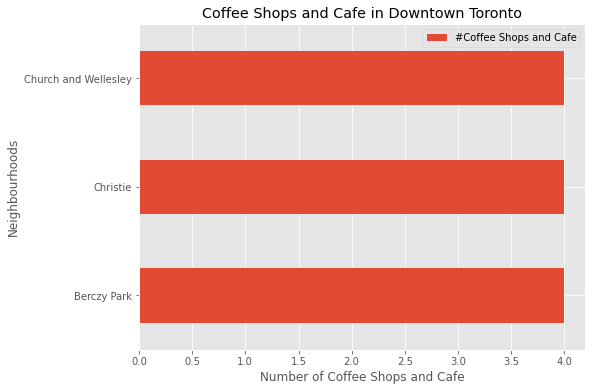

In [35]:


Toronto_Coffee_5 = df_Toronto_Coffee[df_Toronto_Coffee['#Coffee Shops and Cafe'] < 5]

Toronto_Coffee_5.plot(kind='barh', figsize=(8, 6))

plt.ylabel('Neighbourhoods') # add to x-label to the plot
plt.xlabel('Number of Coffee Shops and Cafe') # add y-label to the plot
plt.title('Coffee Shops and Cafe in Downtown Toronto') # add title to the plot

plt.show()
#plt.savefig('plot1.png',bbox_inches='tight')


### Results and Discussion

My analysis shows that Downtown Toronto's neighbourhoods could be clusterd in five groups based on their similarity. There are several different coffee shops and restaurants. Results show that there are four neighbourhoods, **Rosedale**, **Church and Wellesley**, **Christie**, **Berczy Park**, and **CN Tower and Surrounding Areas**, where there are no or fewer than 5 coffee shopes and cafe.
These neighbourhood can be proper locations to open up a new coffee shop. Of course, there should be other considerations, for example, the budgeting and funding for the coffee shop. In some neighbourhoods, rents are higher than other locations. 

### Conclusion

The purpose of this project was to find proper locations to open up a coffee shope. After using different data sets and Foursquare API. Using and analysing data, I could identify some proper locations. 
Final decision on optimal coffee shop location will be made by stakeholders based on specific characteristics of neighbourhoods and locations in every recommended location, taking into consideration additional factors like budgeting and funding, equipment, licenses, and insurance.